In [37]:
#Libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import confusion_matrix

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve

from scipy import stats
from scipy.special import boxcox1p
from scipy.stats import norm

#packages
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error




In [38]:
#Get files
training = pd.read_csv('train.csv')
testing = pd.read_csv('test.csv')

test_id = testing['id']
train_id = training['id']

training.drop("id", axis =1 , inplace = True)
testing.drop("id", axis =1 , inplace = True)

training.drop("ocean_proximity", axis=1, inplace=True)
testing.drop("ocean_proximity", axis=1, inplace=True)


In [39]:
training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10320 entries, 0 to 10319
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           10320 non-null  float64
 1   latitude            10320 non-null  float64
 2   housing_median_age  10320 non-null  float64
 3   total_rooms         10320 non-null  float64
 4   total_bedrooms      10210 non-null  float64
 5   population          10320 non-null  float64
 6   households          10320 non-null  float64
 7   median_income       10320 non-null  float64
 8   median_house_value  10320 non-null  float64
dtypes: float64(9)
memory usage: 725.8 KB


In [40]:
training.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.22     37.77                40.0        494.0           114.0   
1    -122.29     37.76                18.0       2873.0           763.0   
2    -118.48     34.23                29.0       3354.0           707.0   
3    -122.19     37.80                48.0       1694.0           259.0   
4    -121.93     36.63                33.0       1740.0           342.0   

   population  households  median_income  median_house_value  
0       547.0       135.0         2.8015            114800.0  
1      1243.0       663.0         5.1702            265400.0  
2      1752.0       650.0         4.5484            239900.0  
3       610.0       238.0         4.7440            257300.0  
4       638.0       329.0         3.1912            319800.0

In [41]:
missing_values = training.isnull().sum()
missing_values[0:10]

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        110
population              0
households              0
median_income           0
median_house_value      0
dtype: int64

In [42]:
training["total_bedrooms"].fillna(0, inplace= True)

In [43]:
missing_values = training.isnull().sum()
missing_values[0:10]

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
dtype: int64

In [44]:
#assign feature variables

original = training['median_house_value']
training['median_house_value'] = stats.boxcox(training['median_house_value'])[0]

#get fitted parameters
(mu, sigma) = norm.fit(training['median_house_value'])
(mu_norm, sigma_norm) = norm.fit(training['median_house_value'])

original_skew = original.skew()
original_kurt = original.kurt()

transf_skew = training['median_house_value'].skew()
transf_kurt = training['median_house_value'].kurt()


C:\Users\Eduar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Meidan House value density distribution')

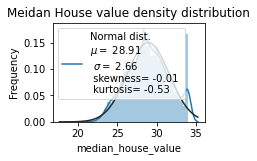

In [45]:
#Now plot the distribution
plt.subplot(221)
sns.distplot(original , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu, sigma,original_skew,original_kurt)],loc='best')
plt.ylabel('Frequency')
plt.title('Meidan House value density distribution')


Text(0.5, 1.0, 'SalePrice Probability Plot')

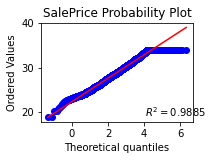

In [46]:
#Get also the QQ-plot
plt.subplot(222)
res = stats.probplot(original, sparams=(2.5,), plot=plt, rvalue=True)
plt.title('SalePrice Probability Plot')


C:\Users\Eduar\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Normalized SalePrice density distribution')

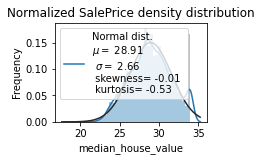

In [47]:
#Now plot Normalized distribution
plt.subplot(223)
sns.distplot(training['median_house_value'] , fit=norm)
plt.legend(['Normal dist. \n$\mu=$ {:.2f} \n $\sigma=$ {:.2f} \n skewness= {:.2f} \n kurtosis= {:.2f}'.format(mu_norm, sigma_norm,transf_skew,transf_kurt)],loc='best')

plt.ylabel('Frequency')
plt.title('Normalized SalePrice density distribution')


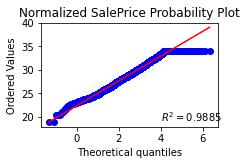

In [48]:
#Get also the QQ-plot for Normalized distribution
plt.subplot(224)
res = stats.probplot(training['median_house_value'], sparams=(2.5,), plot=plt, rvalue=True)
plt.title('Normalized SalePrice Probability Plot')
plt.tight_layout()

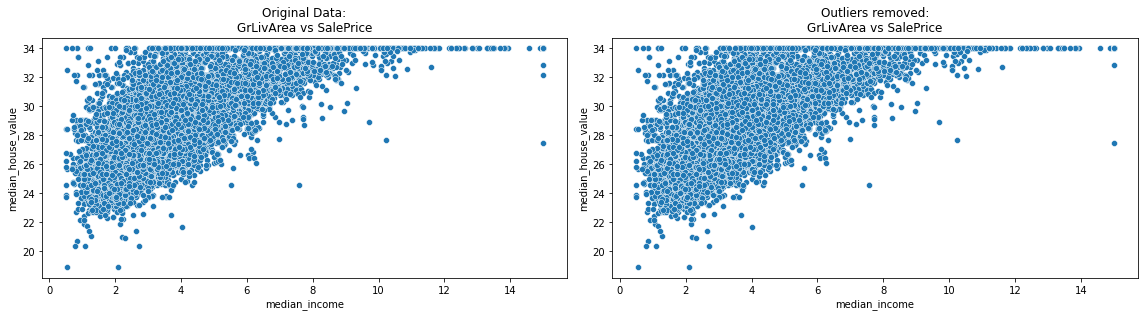

In [49]:
plt.figure(figsize=(16,8))
plt.subplot(221)
sns.scatterplot(x=training['median_income'],y=training['median_house_value'])
plt.title('Original Data:\nGrLivArea vs SalePrice')

# Removing two outliers with larger living area and low sale price
training = training.drop(training.sort_values(by = 'median_income', ascending = False)[:2].index)

plt.subplot(222)
sns.scatterplot(x=training['median_income'],y=training['median_house_value'])
plt.title('Outliers removed:\nGrLivArea vs SalePrice')

plt.tight_layout()

In [50]:
all_data = pd.concat((training, testing)).reset_index(drop=True)
all_data.drop(['median_house_value'], axis =1, inplace =True)

newTrain = training.shape[0]
newTest = testing.shape[0]

y_train = training['median_house_value'].values
y_test = training['median_house_value'].values

In [51]:
def bcox_transform(df):  
    '''
    IN: Original dataframe 
    OUT: Dataframe with box-cox normalized numerical values. 
    Specified skewness threshold 1 and -1 
    '''
    lam = 0.15
    for feat in df._get_numeric_data():
        if df[feat].skew()>1.0 or df[feat].skew()<-1.0:
            df[feat]=boxcox1p(df[feat], lam)
    return df

all_data = bcox_transform(all_data)


# splitting data back to train and test data sets
training = all_data[:newTrain]
testing = all_data[newTrain:]

In [52]:
#split training

X_train = all_data[:training.shape[0]]
X_test = all_data[training.shape[0]:]
y = y_train
n_folds = 15


In [53]:
def k_rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=0).get_n_splits(training.values)
    rsme = np.sqrt(-cross_val_score(model, training.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rsme)

In [54]:
#MODELS
model_ridge = Ridge()
model_lasso = Lasso()
model_elasticNet = ElasticNet(l1_ratio=0.5)



NameError: name 'Lasso' is not defined

In [319]:
# Tunning hyperparameter
# In this example we use alpha as our hyperparameter lambda. 
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]

# Evaluating models through k-fold cross-validation defined earlier
cv_ridge = [k_rmsle_cv(Ridge(alpha = alpha)).mean() 
            for alpha in alphas]

cv_lasso = [k_rmsle_cv(Lasso(alpha = alpha)).mean() 
            for alpha in alphas]

cv_elasticNet = [k_rmsle_cv(ElasticNet(alpha = alpha)).mean() 
            for alpha in alphas]

cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)

Text(0, 0.5, 'rmse')

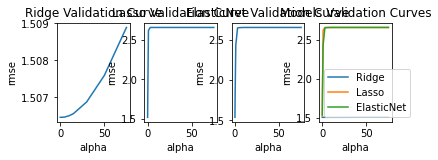

In [320]:

plt.subplot(241)
cv_ridge.plot(title = "Ridge Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_lasso = pd.Series(cv_lasso, index = alphas)
plt.subplot(242)
cv_lasso.plot(title = "Lasso Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

cv_elasticNet = pd.Series(cv_elasticNet, index = alphas)
plt.subplot(243)
cv_elasticNet.plot(title = "ElasticNet Validation Curve")
plt.xlabel("alpha")
plt.ylabel("rmse")

plt.subplot(244)
cv_ridge.plot()
cv_lasso.plot()
cv_elasticNet.plot()
plt.legend(labels=['Ridge','Lasso','ElasticNet'])
plt.title('Models Validation Curves')
plt.xlabel("alpha")
plt.ylabel("rmse")

In [321]:
testing.isnull().sum()

longitude              0
latitude               0
housing_median_age     0
total_rooms            0
total_bedrooms        97
population             0
households             0
median_income          0
dtype: int64

In [322]:
testing["total_bedrooms"].fillna(0, inplace= True)

C:\Users\Eduar\anaconda3\lib\site-packages\pandas\core\series.py:4517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(


In [323]:
testing.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

In [324]:

def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

model_ridge.fit(training, y_train)
model_ridge_pred = model_ridge.predict(training)
ridge_pred = np.expm1(model_ridge.predict(t.valuesvalues))

submission = pd.DataFrame()
submission['id'] = test_id
submission['median_house_value'] = ridge_pred
submissinewmodel_csv('model.csv',index=False)
print("Submission Complete")


Submission Complete
